In [1]:
import itertools
import os
import os.path as osp
import pickle
import urllib
from collections import namedtuple

import numpy as np
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import Linear 

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
# import random


%matplotlib inline

In [2]:
def tensor_from_numpy(x, device):
    return torch.from_numpy(x).to(device)
def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training Loss ')
    plt.show() 

In [35]:
# 超参数定义
LEARNING_RATE = 2e-4 #0.001
# WEIGHT_DACAY = 1e-4
EPOCHS = 400
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [48]:
df = pd.read_csv('../data/xubo_kmer/kmer.csv', header = None)
seqs = df.values[:, : -1].astype(np.float32)
# seqs/=seqs.sum(1, keepdims=True)  
tensor_x = tensor_from_numpy(seqs, DEVICE)

labelList=pd.read_csv('../data/label.csv',header=None)[1]
for i in range(0,len(labelList)):
    labelList[i]+=1
    

In [49]:
seqs.shape

(850, 135)

In [50]:
class AutoEncoder(nn.Module):

    def __init__(self, input_dim):
        super(AutoEncoder,self).__init__()
 
        self.linear1=nn.Linear(input_dim,512)
        self.linear2=nn.Linear(512,512)
        self.linear3=nn.Linear(512 ,64)
        self.linear4=nn.Linear(64,512)
        self.linear5=nn.Linear(512,512)
        self.linear6=nn.Linear(512,input_dim)
    
    def forward(self, feature):
        self.h1 = F.relu(self.linear1( feature))

        self.h2  = F.relu(self.linear2(self.h1))
        self.h2 = F.normalize(self.h2)
        
        self.h3  = F.relu(self.linear3(self.h2))
        self.h3 = F.normalize(self.h3)
        
        self.h4  = F.relu(self.linear4(self.h3))
        self.h4 = F.normalize(self.h4)
        
        self.h5  = F.relu(self.linear5(self.h4))
        self.h5 = F.normalize(self.h5)
        
        self.h6  = self.linear6(self.h5)

        return  self.h6

# class AutoEncoder(nn.Module):

#     def __init__(self, input_dim):
#         super(AutoEncoder,self).__init__()
 
#         self.linear1=nn.Linear(input_dim,940)
#         self.linear2=nn.Linear(940,400)
#         self.linear3=nn.Linear(400,150)
#         self.linear4=nn.Linear(150,36)
#         self.linear5=nn.Linear(36,150)
#         self.linear6=nn.Linear(150,400)
#         self.linear7=nn.Linear(400,940)
#         self.linear8=nn.Linear(940,input_dim)
    
#     def forward(self, feature):
#         self.h1 = F.relu(self.linear1( feature))
#         self.h1 = F.normalize(self.h1)
        
#         self.h2  = F.sigmoid(self.linear2(self.h1))
#         self.h2 = F.normalize(self.h2)
        
#         self.h3 = F.relu(self.linear3( self.h2))
#         self.h3 = F.normalize(self.h3)
        
#         self.h4  = F.sigmoid(self.linear4( self.h3))
#         self.h4 = F.normalize(self.h4)
        
#         self.h5  = F.relu(self.linear5( self.h4))
#         self.h5 = F.normalize(self.h5)
        
#         self.h6  = F.sigmoid(self.linear6( self.h5))
#         self.h6 = F.normalize(self.h6)
        
#         self.h7  = F.relu(self.linear7(self.h6))
#         self.h7 = F.normalize(self.h7)
        
#         self.h8  = self.linear8(self.h7)

#         return  self.h8

In [51]:
model = AutoEncoder(tensor_x.shape[1]).to(DEVICE)
criterion=nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE )

In [52]:
 # 训练主体函数
def train():
    loss_history = []
    val_acc_history = []
    model.train()
 
    for epoch in range(EPOCHS):
         
        logits = model(tensor_x)  # 前向传播
        #train_mask_logits = logits[tensor_train_mask]   # 只选择训练节点进行监督
 
        loss = criterion(logits, tensor_x)
        optimizer.zero_grad()
        loss.backward()     # 反向传播计算参数的梯度
        optimizer.step()    # 使用优化方法进行梯度更新
 
        loss_history.append(loss.item())
 
    return loss_history, model.h3, model.h6

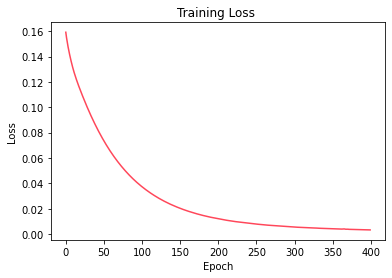

In [53]:
loss,feature_layer, rec_X = train()
 
# print(loss)
plot_loss_with_acc(loss, [])

In [54]:
print(loss[-1])

0.0032539209350943565


In [55]:
feature_np=feature_layer.detach().numpy()
feature_np/=feature_np.sum(1, keepdims=True)
kmeans = KMeans(n_clusters=12,init='k-means++').fit(feature_np)
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

print('purity : ',purity_score(labelList,kmeans.labels_ ))
print('ARI : ',adjusted_rand_score(labelList,kmeans.labels_))
print('NMI : ',normalized_mutual_info_score(labelList,kmeans.labels_ ))

purity :  0.6176470588235294
ARI :  0.42376509224137454
NMI :  0.6046533010090586


In [56]:
np.save("../model/feacture_np.npy",feature_np )
np.save("../model/rec_X.npy", rec_X.detach().numpy() )

In [57]:
class HalfAutoEncoder(nn.Module):
    def __init__(self,linear4,linear5,linear6 ):
        super(HalfAutoEncoder,self).__init__()
        
        self.linear4= linear4
        self.linear5= linear5
        self.linear6= linear6
         
        
    
    def forward(self, h3):
        self.h4  = F.relu(self.linear4(h3))
        self.h4 = F.normalize(self.h4)
        
        self.h5  = F.relu(self.linear5(self.h4))
        self.h5 = F.normalize(self.h5)
        
        self.h6  = self.linear6(self.h5)

        return  self.h6

In [58]:
half_auto_encoder=HalfAutoEncoder(model.linear4, model.linear5, model.linear6).to(DEVICE)
torch.save(half_auto_encoder, '../model/half_auto_encoder.pt')